README:
To run this file, install all the required dependencies in the local system. Now, download any video you want to test this on named "test.mp4" in the same directory this code resides in. Now, create a folder named "frames" and another folder called "test_output" and run the code.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

We basically now want to read the video as a sequence of frames. Here we are just taking a video and saving it as a sequence of frames in some output directory.

In [2]:
def video_to_frames(input_loc, output_loc):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        if not ret:
            continue
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            break

In [3]:
input_loc = 'test.mp4'
output_loc = 'frames'
video_to_frames(input_loc,output_loc)

Number of frames:  300
Converting video..

Done extracting frames.
300 frames extracted


Now, let us read the frames and see the ouput.

In [4]:
imPath = r'frames/'
#cv2.imread(frames/00001)
#imPath = imPath + '\'
for imName in os.listdir(imPath):
    image = os.path.join(imPath) + imName
    print(image)
    frame = cv2.imread(image) 
    frame = cv2.resize(frame,dsize=(600,400))
    cv2.imshow('Display', frame)
    k = cv2.waitKey(5) & 0xff
    if k == 27:
        break

cv2.destroyAllWindows()


frames/00001.jpg
frames/00002.jpg
frames/00003.jpg
frames/00004.jpg
frames/00005.jpg
frames/00006.jpg
frames/00007.jpg
frames/00008.jpg
frames/00009.jpg
frames/00010.jpg
frames/00011.jpg
frames/00012.jpg
frames/00013.jpg
frames/00014.jpg
frames/00015.jpg
frames/00016.jpg
frames/00017.jpg
frames/00018.jpg
frames/00019.jpg
frames/00020.jpg
frames/00021.jpg
frames/00022.jpg
frames/00023.jpg
frames/00024.jpg
frames/00025.jpg
frames/00026.jpg
frames/00027.jpg
frames/00028.jpg
frames/00029.jpg
frames/00030.jpg
frames/00031.jpg
frames/00032.jpg
frames/00033.jpg
frames/00034.jpg
frames/00035.jpg
frames/00036.jpg
frames/00037.jpg
frames/00038.jpg
frames/00039.jpg
frames/00040.jpg
frames/00041.jpg
frames/00042.jpg
frames/00043.jpg
frames/00044.jpg
frames/00045.jpg
frames/00046.jpg
frames/00047.jpg
frames/00048.jpg
frames/00049.jpg
frames/00050.jpg
frames/00051.jpg
frames/00052.jpg
frames/00053.jpg
frames/00054.jpg
frames/00055.jpg
frames/00056.jpg
frames/00057.jpg
frames/00058.jpg
frames/00059.j

The first approach is to read the current image and remove the backgrnd from it. Also called frame differencing.

In [5]:
B = cv2.imread(r'frames/00001.jpg')
I = cv2.imread(r'frames/00280.jpg')


In [6]:
#change the data types so as to read negative values
B = np.float32(B)
I = np.float32(I)
C = (I-B)**2
C.shape

(720, 1280, 3)

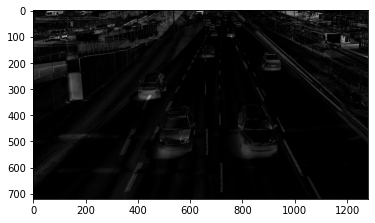

In [7]:
#since c has all the RGB values, sum them to get single grayscale
C2 = np.sum(C,axis = 2)
#C2 here represents the foreground mask now.
plt.imshow(C2,cmap='gray')

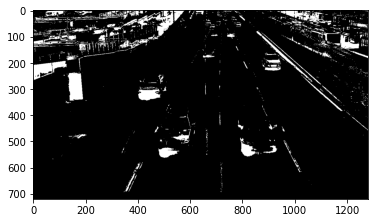

In [8]:
#now let us keep the mean as refence and see the image
plt.imshow(C2>C.mean()+2*C2.std(),cmap = 'gray')

But now we see, in background subtraction it fails when there is change in luminances which  might give us  more noise. SO we basically try to build a probability model for each pixel to predict if it is a backgrnd pixel or not. we thus would like to use gausssian mixture model.

so for frame to frame, we see if it a backgrnd or foregrnd pixel and if it is a foregrdn pixel and if it stays the same for lot of upcoming frames, then it also becomes a part of the backgrnd.

In [9]:
imPath = r'frames/'
fgModel = cv2.createBackgroundSubtractorMOG2()

for imName in os.listdir(imPath):
  image = os.path.join(imPath) + imName
  frame = cv2.imread(image)
  frame = cv2.resize(frame,dsize=(600,400))
  fgmask = fgModel.apply(frame)
  F = np.zeros(frame.shape,np.uint8)
  F[:,:,0],F[:,:,1],F[:,:,2] = fgmask, fgmask, fgmask
  F2 = np.hstack((frame,F))
  cv2.imshow('Mixture of gaussians',F2)
  k = cv2.waitKey(5) & 0xff
  if k == 27:
    break

#cap.release()
cv2.destroyAllWindows()


We would now want to de-noise the foreground mask using some morphological operators.

In [10]:
imPath = r'frames/'
fgModel = cv2.createBackgroundSubtractorMOG2()

for imName in os.listdir(imPath):
  image = os.path.join(imPath) + imName
  frame = cv2.imread(image)
  frame = cv2.resize(frame,dsize=(600,400))
  fgmask = fgModel.apply(frame)

  #We now want to de-noise the mask
  K_r = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  fgmask = cv2.morphologyEx(np.float32(fgmask),cv2.MORPH_OPEN,K_r)
  F = np.zeros(frame.shape,np.uint8)
  F[:,:,0],F[:,:,1],F[:,:,2] = fgmask, fgmask, fgmask
  F2 = np.hstack((frame,F))
  cv2.imshow('Morphological operators',F2)
  k = cv2.waitKey(5) & 0xff
  if k == 27:
    break

#cap.release()
cv2.destroyAllWindows()


Now, the next problem we tackle is, what if we have a changing backgrnd, i.e, say we have trees on the side of a road on a windy day as the backgrnd. Since the leaves keep moving, it is considered as active change and is shown which is not required, so now we want to tackle that.

One major obsevation is that, the objects of interest are very large connected components. rathe than small leaves flickering, areas of intrest are bigger connected components such as a car or a bus.

In [11]:
def f_keepLargeComponents(I,th):
  #making it a boolean array
  R = np.zeros(I.shape)<0
  #this unique func finds all the unique values in the flattened array.
  unique_labels = np.unique(I.flatten())

  #Now iterate the labels
  for label in unique_labels:
    if label == 0:
      pass
    else:
      #compute all the pixels beloging to that label
      I2 = I==label
      if np.sum(I2)>th:
        R = R | I2

  return np.float32(255*R)



In [12]:
imPath = r'frames/'
fgModel = cv2.createBackgroundSubtractorMOG2()

for imName in os.listdir(imPath):
  image = os.path.join(imPath) + imName
  frame = cv2.imread(image)
  frame = cv2.resize(frame,dsize=(600,400))
  fgmask = fgModel.apply(frame)

  #We now want to de-noise the mask
  K_r = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  fgmask = cv2.morphologyEx(np.float32(fgmask),cv2.MORPH_OPEN,K_r)

  #Start doing the connected components here.
  num_labels,labels_im = cv2.connectedComponents(np.array(fgmask>0,np.uint8))
  fgmask = f_keepLargeComponents(labels_im,1000)


  F = np.zeros(frame.shape,np.uint8)
  F[:,:,0],F[:,:,1],F[:,:,2] = fgmask, fgmask, fgmask
  F2 = np.hstack((frame,F))
  cv2.imshow('Connnected components',F2)
  k = cv2.waitKey(1) & 0xff
  if k == 27:
    break

#cap.release()
cv2.destroyAllWindows()


Now, we would like to only save the changes which are big and save them on our local system. As if a change is only for 1 frame, it might just be noise, so we want to keep the changes which consecutively last for 4-5 frames.

In [13]:
import cvlib as cv
from cvlib.object_detection import draw_bbox
def f_saveSeq(C,counter,th,outPutPath):
  if len(C) < th:
    pass
  else:
    k = 1
    for frame in C:
      imName = str(counter) + '_' + str(k) + '.jpg'
      finalPath = os.path.join(outPutPath,imName)
      bbox,labels,conf = cv.detect_common_objects(frame)
      frame = draw_bbox(frame,bbox,labels,conf)
      cv2.imwrite(finalPath,frame)
      k+=1 


In [14]:
imPath = r'frames/'
fgModel = cv2.createBackgroundSubtractorMOG2()
leastNumOfFrames = 5
idx = []
C = []
counter = 0
outPutPath = r'test_output/'

for imName in os.listdir(imPath):
  counter+=1
  image = os.path.join(imPath) + imName
  frame = cv2.imread(image)
  frame = cv2.resize(frame,dsize=(600,400))
  fgmask = fgModel.apply(frame)

  #We now want to de-noise the mask
  K_r = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  fgmask = cv2.morphologyEx(np.float32(fgmask),cv2.MORPH_OPEN,K_r)

  #Start doing the connected components here.
  num_labels,labels_im = cv2.connectedComponents(np.array(fgmask>0,np.uint8))
  fgmask = f_keepLargeComponents(labels_im,1000)

  #now, if the foregrnd mask does not have all backgrnd but has some foregrnd values, then
  if np.sum(fgmask)>0:
    idx.append(counter)
    C.append(frame)
  #if the frames are consecutive,
  if len(idx) >= 2 and idx [-1] > idx[-2] + 1:
    f_saveSeq(C, counter, leastNumOfFrames, outPutPath)
    idx = []
    C = []



  F = np.zeros(frame.shape,np.uint8)
  F[:,:,0],F[:,:,1],F[:,:,2] = fgmask, fgmask, fgmask
  F2 = np.hstack((frame,F))
  cv2.imshow('Before object detection',F2)
  k = cv2.waitKey(1) & 0xff
  if k == 27:
    break

f_saveSeq(C, counter, leastNumOfFrames, outPutPath)
#cap.release()
cv2.destroyAllWindows()


Now let us view the frames as a video and save the interesting part by detecting the objects. As we can see, the number of output frames will always be lesser than the input frames as we discard all the un-intresting frames.

In [21]:
def f_displaySeq(outPutPath):
  for imName in os.listdir(outPutPath):
    image = os.path.join(outPutPath) + imName

    frame = cv2.imread(image)
    frame = cv2.resize(frame,dsize=(600,400))
    cv2.imshow('Display', frame)
    k = cv2.waitKey(5) & 0xff
    if k == 27:
      break

  cv2.destroyAllWindows()

In [22]:
pth = r'test_output/'
f_displaySeq(pth)